# Dogs vs. Cats

ДАНИЛЬЧЕНКО ВАДИМ

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [62]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [63]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [64]:
import re
from random import shuffle
from glob import glob

# train_files = glob('../input/train/*.jpg')
# test_files = glob('../input/test/*.jpg')

train_files = glob('../input/train/*.jpg')
test_files = glob('../input/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

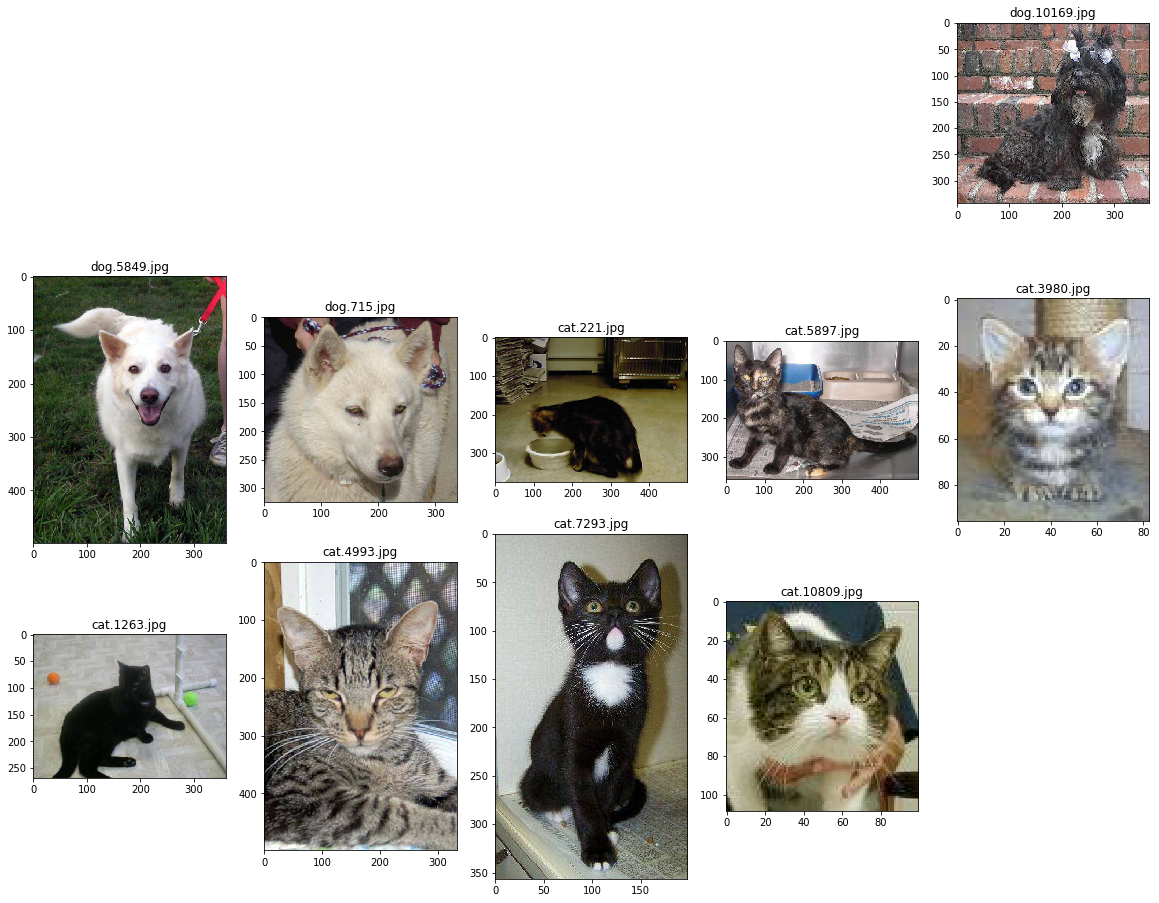

In [65]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[12495:12505], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [66]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [67]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [68]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Делаем несколько дропаутовобавляем полносвязный слой

In [69]:
x = base_model.layers[-1].output
x = keras.layers.Convolution2D(1024, (2, 2), strides=2, padding='valid', name='conv2_new')(x)

x = keras.layers.Flatten()(x)
x = keras.layers.PReLU(shared_axes=[1, 1], name='prelu1')(x)
x = keras.layers.Dense(2048, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(1024,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l2(1e-5))(x)
x = keras.layers.Dense(512,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l2(1e-6))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l2(1e-7))(x)
x = keras.layers.Dense(128,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l2(1e-8))(x)

x = keras.layers.Dense(1,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l2(1e-9))(x)

# topLayersModel = Model(inputs=base_model.input, outputs=x)


model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [70]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Компилируем модель и запускаем обучение

In [71]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [72]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 5  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=50,  # число вызовов генератора за эпоху
        epochs=15,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/15
50/50 [==============================] - 13s 251ms/step - loss: 0.9830 - acc: 0.5094 - val_loss: 0.8263 - val_acc: 0.2000
Epoch 2/15
50/50 [==============================] - 6s 126ms/step - loss: 0.7702 - acc: 0.4969 - val_loss: 0.7197 - val_acc: 1.0000
Epoch 3/15
50/50 [==============================] - 7s 145ms/step - loss: 0.3695 - acc: 0.8975 - val_loss: 0.0905 - val_acc: 1.0000
Epoch 4/15
50/50 [==============================] - 7s 142ms/step - loss: 0.2386 - acc: 0.9588 - val_loss: 0.0958 - val_acc: 1.0000
Epoch 5/15
50/50 [==============================] - 7s 141ms/step - loss: 0.1784 - acc: 0.9725 - val_loss: 0.1008 - val_acc: 1.0000
Epoch 6/15
50/50 [==============================] - 7s 145ms/step - loss: 0.1761 - acc: 0.9675 - val_loss: 0.0868 - val_acc: 1.0000
Epoch 7/15
50/50 [==============================] - 7s 145ms/step - loss: 0.1454 - acc: 0.9812 - val_loss: 0.0764 - val_acc: 1.0000
Epoch 8/15
50/50 [==============================] - 7s 144ms/step - loss: 0

In [73]:
model.save('../cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [74]:
%%time
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

CPU times: user 1min 56s, sys: 46.9 s, total: 2min 43s
Wall time: 1min 34s


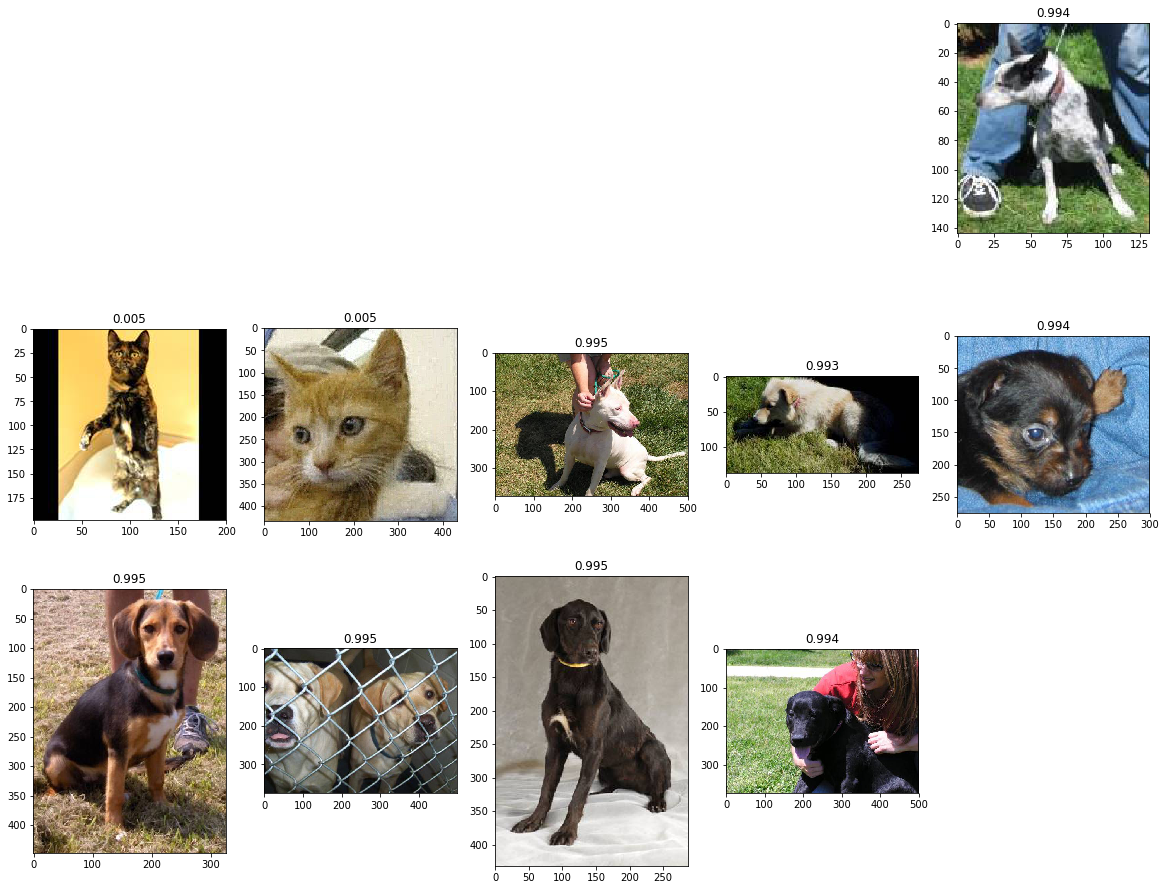

In [75]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [92]:
with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), int(np.round(score,0))))

<a href="../"> Download File </a>